In [10]:
import numpy as np
from scipy.io import loadmat, wavfile
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib as mpl
from Signal_Analysis.features.signal import get_F_0, get_HNR
from importlib import reload
import wave
import json
from os import path
from vosk import Model, KaldiRecognizer,SetLogLevel


# tools work in progress
import tools
reload(tools)
from tools import *

plt.style.use("dark_background")
mpl.rcParams["lines.linewidth"] = 0.5
plt.close("all")

In [11]:
model_path = "models/vosk-model-en-us-0.22"
#model_path = "models/vosk-model-small-en-us-0.15"
if not "model" in locals():
    model = Model(model_path)

In [12]:
audio_filename = "wav_examples/female_canoe.wav"
wf = wave.open(audio_filename, "rb")

print("# Samples       ", wf.getnframes())
print("Sample frequency",wf.getframerate())

# Samples        132480
Sample frequency 32000


## Recognize words

In [13]:
wf = wave.open(audio_filename, "rb")

rec = KaldiRecognizer(model, wf.getframerate())
rec.SetWords(True)

# list of word dictionaries
results = []

# recognize speech, vosk
while True:
    data = wf.readframes(wf.getframerate())
    if len(data) == 0: # if end
        break
    if rec.AcceptWaveform(data):
        part_result = json.loads(rec.Result())
        results.append(part_result)

wf.close()  # close audiofile

part_result = json.loads(rec.FinalResult())
results.append(part_result)

words = []
for sentence in results:
    if len(sentence) == 1:
        # sometimes there are bugs in recognition 
        # and it returns an empty dictionary
        # {'text': ''}
        continue
    for w in sentence['result']:
        words.append(w)  # and add it to list


def print_w(w):
    """prints the word, and information from a word dictionary"""
    print("{:20} from {:.2f} to {:.2f} sec, confidence: {:.2f}%".format(
        w["word"]+" " +("-"*(20-len(w["word"]))), w["start"], w["end"], w["conf"]*100))

# print info
for w in words:
    print_w(w)


the ----------------- from 0.99 to 1.17 sec, confidence: 100.00%
entry --------------- from 1.17 to 1.53 sec, confidence: 100.00%
could --------------- from 1.53 to 1.74 sec, confidence: 100.00%
double -------------- from 1.74 to 2.16 sec, confidence: 100.00%
as ------------------ from 2.16 to 2.34 sec, confidence: 100.00%
a ------------------- from 2.34 to 2.40 sec, confidence: 100.00%
canoe --------------- from 2.40 to 2.79 sec, confidence: 100.00%
dock ---------------- from 2.79 to 3.33 sec, confidence: 100.00%


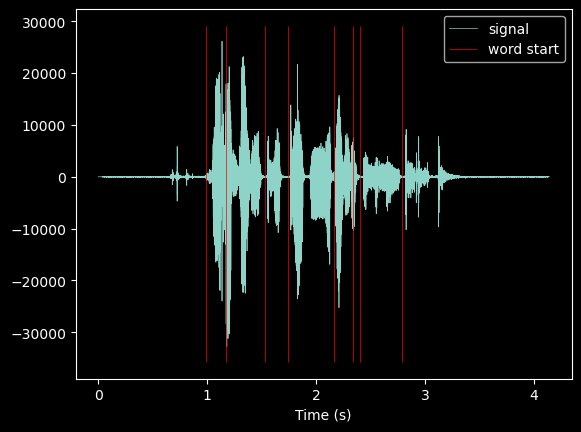

In [14]:
Fs, audio = wavfile.read(audio_filename)

tt = np.linspace(0,len(audio)/Fs,len(audio))

plt.figure()
plt.plot(tt,audio,label = "signal")
plt.xlabel("Time (s)")
ymin,ymax = plt.ylim()
plt.vlines([w["start"] for w in words],ymin,ymax,"r",label="word start")
plt.legend()
plt.show()

### Test timestamps

Maybe short words are not perfect

In [15]:
for w in words:
    print(int(w["start"]*Fs), int(w["end"]*Fs))

31680 37440
37440 48960
48960 55680
55680 69120
69120 74880
74880 76800
76800 89280
89280 106560


In [16]:
frames = []
for w in words:
    frames.append(audio[int(w["start"]*Fs):int(w["end"]*Fs)])

out_name = "words_sep_"+audio_filename[:-4].split("/")[-1]

print(out_name)

out = stitch_frames(frames, fade_pow=  0, padding = 1*Fs)
wavfile.write(path.join("output",out_name+".wav"),Fs,out)

words_sep_female_canoe


#### one word?